# Neo Platform Certification {-}

You can specify a build number in the **current_build** variable to generate a report for a specific build version, otherwise it will default to the most recent 7.1.0 build.

In [58]:
release="7.1.0"
current_build=""

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import matplotlib.patches as mpatches
import json
import plotly.express as px
import plotly.graph_objects as go
import plotly
from plotly.offline import *

plt.rcParams['figure.figsize'] = (20.0, 12.0)
plt.rcParams['font.family'] = "serif"

In [60]:
def run_query(query, host="172.23.99.54", port=8093, username="Administrator", password="password", param=None):
    url_base = f"http://{host}:{port}/query/service"
    params = {'statement': query, 'scan_consistency': 'REQUEST_PLUS'}
    if param:
        params.update(param)
    response = requests.get(url=url_base, params=params, auth = requests.auth.HTTPBasicAuth(username, password))
    return response.json()

In [61]:
if type(current_build) != type("") or len(str(current_build)) != 4:
    query_current_weekly_build = f'SELECT raw `build` FROM server WHERE `build` < "{release}." GROUP BY `build` HAVING sum(totalCount) > 10000 ORDER BY `build` DESC LIMIT 1'
    current_result = run_query(query=query_current_weekly_build, param={'$version': f'"{release}-0000"'})
    current_build = current_result['results'][0].split("-", 1)[1]

In [62]:
result = run_query(query='SELECT a.job AS `job`, ROUND((SUM(a.totalCount)-SUM(a.failCount))/SUM(a.totalCount)*100) as `0_percent`, MAX(CASE WHEN a.platform = "rhel8" THEN a.result END) AS `rhel8`, MAX(CASE WHEN a.platform = "centosnonroot" THEN a.result END) AS `centosnonroot`, MAX(CASE WHEN a.platform = "debian10" THEN a.result END) AS `debian10`, MAX(CASE WHEN a.platform = "ubuntu20" THEN a.result END) AS `ubuntu20`, MAX(CASE WHEN a.platform = "suse15" THEN a.result END) AS `suse15`, MAX(CASE WHEN a.platform = "oel8" THEN a.result END) AS `oel8`, MAX(CASE WHEN a.platform = "windows" THEN a.result END) AS `windows`, MAX(CASE WHEN a.platform = "ipv6" THEN a.result END) AS `ipv6`, MAX(CASE WHEN a.platform = "centos" THEN a.result END) AS `ce` FROM ( SELECT CASE WHEN name LIKE "centos-ipv6%" THEN "ipv6" ELSE SPLIT(name,"-")[0] END AS platform, CASE WHEN name LIKE "centos-ipv6%" THEN REPLACE(SUBSTR(name, LENGTH(SPLIT(name,"-")[0])+6), "ce_", "") ELSE REPLACE(SUBSTR(name, LENGTH(SPLIT(name,"-")[0])+12), "ce_", "") END AS job, CASE WHEN result in [\'ABORTED\', \'FAILURE\'] THEN 0 ELSE ROUND(100*(totalCount-failCount)/totalCount) END AS result, totalCount, failCount FROM server WHERE `build`=$version AND (name LIKE "%os_certify%" OR (name LIKE "centos-ipv6%" AND name NOT LIKE "centos-ipv6_sanity%"))) AS a WHERE a.job not in [\'analytics_rest\', \'obj-ipv6\', \'ent-backup-restore\'] GROUP BY job ORDER BY `job` ASC, job', param={'$version': f'"{release}-{current_build}"'})

job_list = []
for elements in result['results']:
    job_list.append(elements['job'])

cutResult = result['results'].copy()
for i in range(0, len(cutResult)):
    cutResult[i].pop("job")
    cutResult[i].pop("0_percent")
    for j in cutResult[i].keys():
        if cutResult[i][j] == None:
            cutResult[i][j] = float("nan")

In [63]:
df = pd.DataFrame(cutResult, index=job_list)

## Job Summary Heatmap

This chart represents the percent pass rate for a given area on each targeted platform. It is a heatmap graph where each cell varies in color from red to green. Blank cells are either not applicable or do not have run result at this point. Red cells with 0 percent either failed or aborted.

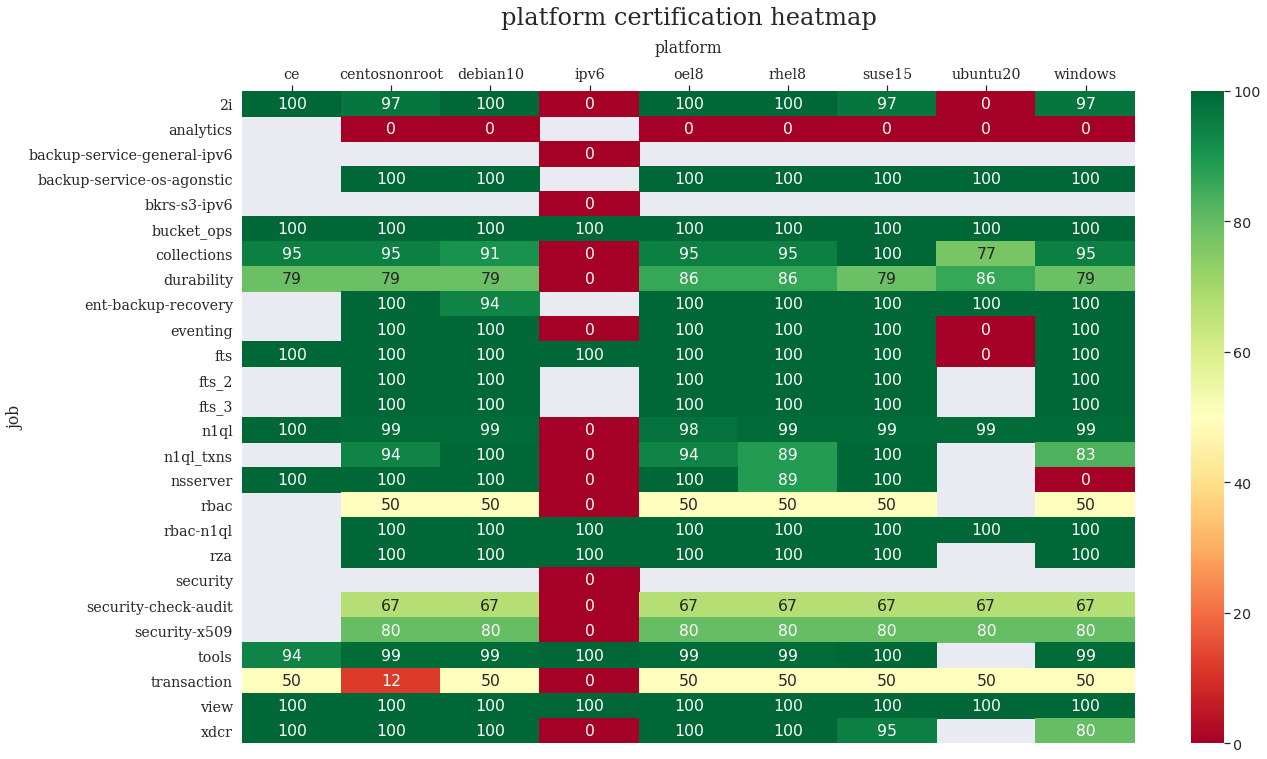

In [64]:
fig, ax = plt.subplots()

sns.set(font_scale=1.3)
fig = sns.heatmap(df, center=50, cmap="RdYlGn", annot=True, fmt=".0f")
fig.set(xlabel='platform', ylabel='job')
fig.set_title("platform certification heatmap", pad=15).set_fontsize('24')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 15

plt.show()


## Top (15) Failing Jobs

In [65]:
query_failed_certify_jobs = f'SELECT url || to_string(build_id) as `joburl`, CASE WHEN name LIKE "centos-ipv6%" THEN "ipv6" ELSE SPLIT(name,"-")[0] END AS `platform`, name AS `job`, failCount as `failures` FROM server WHERE `build`=$version AND (name LIKE "%os_certify%" OR (name LIKE "centos-ipv6%" AND name NOT LIKE "centos-ipv6_sanity%")) AND result != "SUCCESS" ORDER by `failures` DESC, os, `job` LIMIT 15'
result0 = run_query(query=query_failed_certify_jobs, param={'$version': f'"{release}-{current_build}"'})


def make_clickable(url, name):
    return '<a href="{}" rel="noopener noreferrer" target="_blank">{}</a>'.format(url,name)

df = pd.DataFrame(result0['results'])
df['job'] = df.apply(lambda x: make_clickable(x['joburl'], x['job']), axis=1)
df = df.drop('joburl', axis=1)

df.style

,failures,job,platform
0,10,centosnonroot-os_certify_analytics,centosnonroot
1,10,debian10-os_certify_analytics,debian10
2,10,oel8-os_certify_analytics,oel8
3,10,rhel8-os_certify_analytics,rhel8
4,10,suse15-os_certify_analytics,suse15
5,10,ubuntu20-os_certify_analytics,ubuntu20
6,10,windows-os_certify_analytics,windows
7,7,centosnonroot-os_certify_transaction,centosnonroot
8,5,ubuntu20-os_certify_collections,ubuntu20
9,4,centos-os_certify_ce_tools,centos


## Comparison of Pass Rates Between Consecutive Builds

This chart will display the overall pass rate of each platform for the current build and a number of the immediately prior builds. You can change the **limit** variable to change how many builds in total are displayed.

You can also click on each build in the legend at the top to toggle them on or off, or double click on a build to hide all bars except for that build. You can double click on a hidden build to toggle all data back to shown.

In [56]:
limit = 5

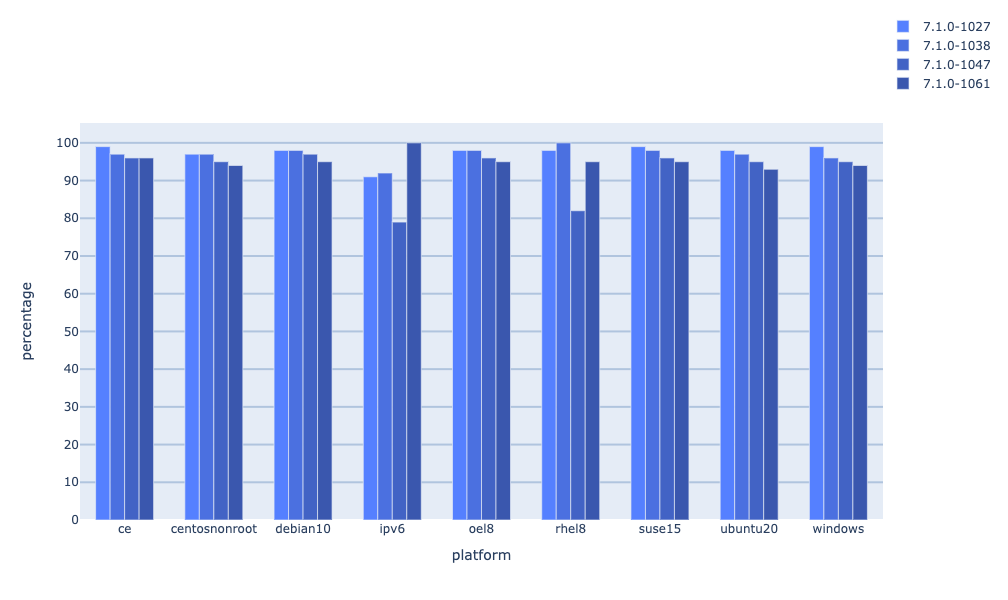

In [57]:
query_last_weekly_build = f'SELECT raw `build` FROM server WHERE `build` <= $version AND `build` > "{release}" GROUP BY `build` HAVING sum(totalCount) > 10000 ORDER BY `build` DESC LIMIT { limit }'
query_pct = 'SELECT a.`build` as `build`, ROUND((SUM(CASE WHEN a.platform = "rhel8" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "rhel8" THEN a.failCount END))/SUM(CASE WHEN a.platform = "rhel8" THEN a.totalCount END)*100,0) AS `rhel8`, ROUND((SUM(CASE WHEN a.platform = "centosnonroot" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "centosnonroot" THEN a.failCount END))/SUM(CASE WHEN a.platform = "centosnonroot" THEN a.totalCount END)*100,0) AS `centosnonroot`, ROUND((SUM(CASE WHEN a.platform = "debian10" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "debian10" THEN a.failCount END))/SUM(CASE WHEN a.platform = "debian10" THEN a.totalCount END)*100,0) AS `debian10`, ROUND((SUM(CASE WHEN a.platform = "ubuntu20" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "ubuntu20" THEN a.failCount END))/SUM(CASE WHEN a.platform = "ubuntu20" THEN a.totalCount END)*100,0) AS `ubuntu20`, ROUND((SUM(CASE WHEN a.platform = "suse15" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "suse15" THEN a.failCount END))/SUM(CASE WHEN a.platform = "suse15" THEN a.totalCount END)*100,0) AS `suse15`, ROUND((SUM(CASE WHEN a.platform = "oel8" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "oel8" THEN a.failCount END))/SUM(CASE WHEN a.platform = "oel8" THEN a.totalCount END)*100,0) AS `oel8`, ROUND((SUM(CASE WHEN a.platform = "windows" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "windows" THEN a.failCount END))/SUM(CASE WHEN a.platform = "windows" THEN a.totalCount END)*100,0) AS `windows`, ROUND((SUM(CASE WHEN a.platform = "ipv6" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "ipv6" THEN a.failCount END))/SUM(CASE WHEN a.platform = "ipv6" THEN a.totalCount END)*100,0) AS `ipv6`, ROUND((SUM(CASE WHEN a.platform = "centos" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "centos" THEN a.failCount END))/SUM(CASE WHEN a.platform = "centos" THEN a.totalCount END)*100,0) AS `ce` FROM ( SELECT `build`, name, totalCount, failCount, CASE WHEN name LIKE "centos-ipv6%" THEN "ipv6" ELSE SPLIT(name,"-")[0] END AS platform FROM server WHERE `build` in $version AND (name LIKE "%os_certify%" OR (name LIKE "centos-ipv6%" AND name NOT LIKE "centos-ipv6_sanity%"))) AS a GROUP BY `build` ORDER BY `build` ASC'
result1 = run_query(query=query_last_weekly_build, param={'$version': f'"{release}-{current_build}"'})
weekly_builds = result1['results']
result1 = run_query(query=query_pct, param={'$version': json.dumps(weekly_builds)})

color_var = 255
barGraph = []
for entry in result1['results']:
    build = entry.pop('build')
    entry = pd.json_normalize(entry)
    bar = f"go.Bar(name=str(build), x=entry.columns, y=entry.iloc[0], marker_color='rgb({color_var/3},{color_var/2},{color_var})')"
    barGraph.append(eval(bar))
    color_var = color_var * (1 - 0.6/limit)

groupedBarGraph = go.Figure(data=barGraph)
groupedBarGraph.update_layout(
    barmode='group',
    bargap=.35,
    legend=dict(y=1.28, x=1),
    height=600
)
groupedBarGraph.update_xaxes(title=dict(text="platform"))
groupedBarGraph.update_yaxes(title=dict(text="percentage"), tickvals=[0,10,20,30,40,50,60,70,80,90,100], gridcolor="lightsteelblue", gridwidth=2)

plotly.offline.iplot(groupedBarGraph, filename='jupyter-chart.html')

